In [12]:
import os
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn import set_config

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TTill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TTill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\TTill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
data = 'data'
path = os.path.join(parent, data, 'goemotions.csv')
df = pd.read_csv(path)
print(df.head())

                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_id  \
0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   

    created_utc  rater_id  example_very_unclear  admiration  ...  love  \
0  1.548381e+09         1                 False           0  ...     0   
1  1.548084e+09        37               

In [14]:
print(df.columns)
print(df.shape)

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
(70000, 37)


In [17]:
def processText(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

In [18]:
x = df['text'].apply(processText)
y = df.iloc[:, 9:]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y.idxmax(axis=1)
)

In [19]:
class_counts = y.sum(axis=0)
min_counts = y.min(axis=0) 

print(class_counts)
print(min_counts)

admiration         5647
amusement          3081
anger              2589
annoyance          4443
approval           5928
caring             1988
confusion          2471
curiosity          3267
desire             1248
disappointment     2771
disapproval        3774
disgust            1704
embarrassment       817
excitement         1900
fear               1048
gratitude          3863
grief               227
joy                2607
love               2745
nervousness         598
optimism           2887
pride               452
realization        2867
relief              452
remorse             849
sadness            2193
surprise           1806
neutral           18423
dtype: int64
admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    0
disapproval       0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude      

In [23]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True
    )),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(
        n_estimators=300,
        max_depth=30,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight='balanced_subsample',  
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )))
])

set_config(display='diagram')
pipeline

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=20000, min_df=2,
                                 ngram_range=(1, 3), strip_accents='unicode',
                                 sublinear_tf=True)),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                        max_depth=30,
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=4,
                                                                        n_estimators=300,
                                                                        n_jobs=-1,
                                                                        random_state=42)))])

In [24]:
param_grid = {
    'tfidf__max_features': [10000, 20000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__estimator__n_estimators': [150, 300],
    'classifier__estimator__max_depth': [15, 30],
    'classifier__estimator__min_samples_split': [2, 4],
    'classifier__estimator__min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=3,
    scoring='accuracy',
    error_score='raise'
)

In [25]:
history = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


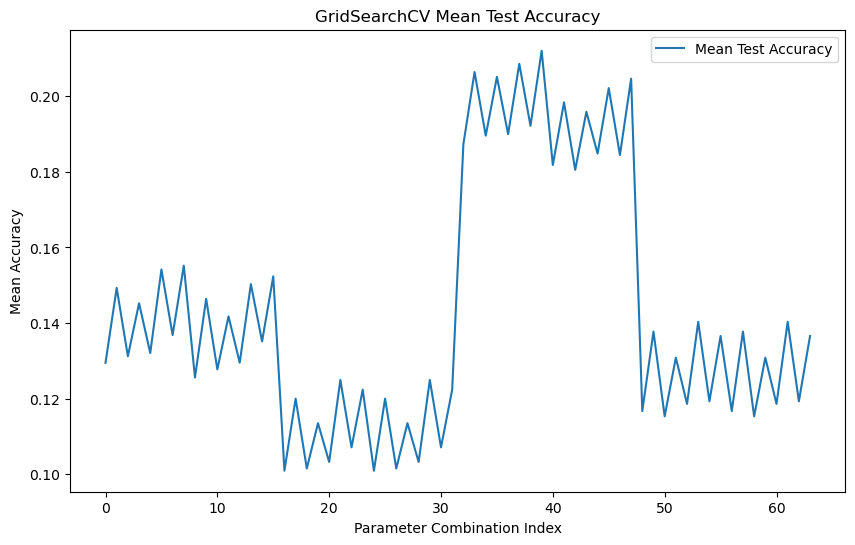

In [26]:
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(results['mean_test_score'], label='Mean Test Accuracy')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean Accuracy')
plt.title('GridSearchCV Mean Test Accuracy')
plt.legend()
plt.show()

In [28]:
print("\nBest parameters:", grid_search.best_params_)
print("Making predictions...")
y_pred = grid_search.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y.columns))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nPer-emotion accuracy:")
per_emotion_accuracy = {}
for i, emotion in enumerate(y.columns):
    acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    per_emotion_accuracy[emotion] = acc
    print(f"{emotion}: {acc:.4f}")


Best parameters: {'classifier__estimator__max_depth': 30, 'classifier__estimator__min_samples_leaf': 1, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__n_estimators': 300, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Making predictions...

Classification Report:
                precision    recall  f1-score   support

    admiration       0.42      0.56      0.48      1126
     amusement       0.52      0.63      0.57       616
         anger       0.26      0.42      0.32       514
     annoyance       0.18      0.33      0.24       880
      approval       0.21      0.30      0.25      1194
        caring       0.20      0.30      0.24       403
     confusion       0.17      0.29      0.21       499
     curiosity       0.20      0.25      0.22       648
        desire       0.23      0.31      0.27       252
disappointment       0.14      0.21      0.17       548
   disapproval       0.16      0.34      0.21       757
       disgust       0.22

c:\Users\TTill\anaconda3\envs\keji\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TTill\anaconda3\envs\keji\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

In [ ]:
def predict_emotions(text, model):
    processed_text = processText(text)
    prediction = model.predict([processed_text])
    emotions_predicted = []
    for i, emotion in enumerate(y.columns):
        if prediction[0][i] == 1:
            emotions_predicted.append(emotion)
    return emotions_predicted



In [34]:
sample = "I'm happy the model is finished training"
best_model = grid_search.best_estimator_
emotions = predict_emotions(sample, best_model)
print(f"Sample text: {sample}")
print(f"Predicted emotions: {emotions}")

Sample text: I'm happy the model is finished training
Predicted emotions: ['caring', 'excitement', 'joy']


In [35]:
def predict_emotions(text, model):
    processed_text = processText(text)  # Assuming processText is defined
    prediction = model.predict([processed_text])
    emotion_scores = {}
    for i, emotion in enumerate(y.columns):  # y.columns should be the list of emotions
        # Assuming the prediction is in probabilities (e.g., softmax output)
        emotion_scores[emotion] = prediction[0][i]  # Store the score for each emotion
    return emotion_scores

sample = "I'm happy the model is finished training"
best_model = grid_search.best_estimator_  # Assuming grid_search is defined
emotion_scores = predict_emotions(sample, best_model)

print(f"Sample text: {sample}")
print("Predicted emotions and their scores:")
for emotion, score in emotion_scores.items():
    print(f"{emotion}: {score:.2f}")


Sample text: I'm happy the model is finished training
Predicted emotions and their scores:
admiration: 0.00
amusement: 0.00
anger: 0.00
annoyance: 0.00
approval: 0.00
caring: 1.00
confusion: 0.00
curiosity: 0.00
desire: 0.00
disappointment: 0.00
disapproval: 0.00
disgust: 0.00
embarrassment: 0.00
excitement: 1.00
fear: 0.00
gratitude: 0.00
grief: 0.00
joy: 1.00
love: 0.00
nervousness: 0.00
optimism: 0.00
pride: 0.00
realization: 0.00
relief: 0.00
remorse: 0.00
sadness: 0.00
surprise: 0.00
neutral: 0.00


In [36]:
def predict_emotions(text, model):
    processed_text = processText(text)  # Assuming processText is defined
    prediction = model.predict([processed_text])
    emotion_scores = []
    for i in range(len(y.columns)):  # Assuming y.columns is the list of emotions
        emotion_scores.append(float(prediction[0][i]))  # Append the score as a float
    return emotion_scores

sample = "I'm happy the model is finished training"
best_model = grid_search.best_estimator_  # Assuming grid_search is defined
emotion_scores = predict_emotions(sample, best_model)

print(f"Sample text: {sample}")
print(f"Predicted emotion scores (vector): {emotion_scores}")


Sample text: I'm happy the model is finished training
Predicted emotion scores (vector): [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [41]:
import numpy as np

In [ ]:
def predict_emotions(text, model):
    processed_text = processText(text)  # Assuming processText is defined
    # Get the prediction probabilities
    prediction_probabilities = model.predict_proba([processed_text])
    
    # Print the type and contents of prediction_probabilities to understand the structure
    print("Prediction probabilities type:", type(prediction_probabilities))
    print("Prediction probabilities:", prediction_probabilities)
    print("Prediction probabilities shape:", len(prediction_probabilities), len(prediction_probabilities[0]))

    emotion_scores = []
    
    # Assuming y.columns contains the list of emotion names
    for i in range(len(y.columns)):  # Loop over the emotions
        # Extract the highest probability from the pair
        emotion_prob = max(prediction_probabilities[i][0])  # Get the max probability for each emotion
        
        print(f"Prediction for emotion {y.columns[i]}: {emotion_prob}")
        
        # Convert to float percentage and append to emotion_scores
        emotion_scores.append(float(emotion_prob) * 100)  # Multiply by 100 for percentage
    
    return emotion_scores

sample = "I love you"
best_model = grid_search.best_estimator_  # Assuming grid_search is defined
emotion_scores = predict_emotions(sample, best_model)

print(f"Sample text: {sample}")
print(f"Predicted emotion scores (vector): {emotion_scores}")


Prediction probabilities type: <class 'list'>
Prediction probabilities: [array([[0.51569203, 0.48430797]]), array([[0.56290772, 0.43709228]]), array([[0.58173812, 0.41826188]]), array([[0.59427071, 0.40572929]]), array([[0.56563039, 0.43436961]]), array([[0.56770931, 0.43229069]]), array([[0.61048097, 0.38951903]]), array([[0.58507435, 0.41492565]]), array([[0.59370742, 0.40629258]]), array([[0.59101503, 0.40898497]]), array([[0.58396512, 0.41603488]]), array([[0.60855952, 0.39144048]]), array([[0.63455039, 0.36544961]]), array([[0.53613862, 0.46386138]]), array([[0.61522089, 0.38477911]]), array([[0.60137096, 0.39862904]]), array([[0.68861667, 0.31138333]]), array([[0.51581072, 0.48418928]]), array([[0.41195023, 0.58804977]]), array([[0.62156325, 0.37843675]]), array([[0.60540798, 0.39459202]]), array([[0.60460094, 0.39539906]]), array([[0.56650392, 0.43349608]]), array([[0.65495294, 0.34504706]]), array([[0.6665613, 0.3334387]]), array([[0.60697842, 0.39302158]]), array([[0.60702906,